In [81]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

sns.set_style('whitegrid')


In [82]:
# === User-Tunable Configuration ===
DATA_PATH = Path("../data/specific_assets_dataset_minute_granularity.csv")
EXPECTED_COLUMNS = [
    'time',
    'BTC_price', 'BTC_volume',
    'AAVE_price', 'AAVE_volume',
    'SOL_price', 'SOL_volume',
    'STRK_price', 'STRK_volume',
    'ETH_price', 'ETH_volume',
    'OP_price', 'OP_volume',
    'UNI_price', 'UNI_volume',
    'LINK_price', 'LINK_volume',
    'MKR_price', 'MKR_volume',
    'ARB_price', 'ARB_volume',
    'AVAX_price', 'AVAX_volume',
    'BNB_price', 'BNB_volume',
    'NEAR_price', 'NEAR_volume',
    'ADA_price', 'ADA_volume',
    'POL_price', 'POL_volume'
]
LOOKBACK_WINDOWS = [5, 15, 60]  # minutes
HORIZON = 20  # prediction horizon (minutes)
CONFIDENCE_THRESHOLD = 0.55  # probability threshold to enter trades
TRAIN_TEST_SPLIT = 0.7  # fraction of data for training (rest is test)
ASSET_TARGET = "ETH"
ASSET_BETA = "BTC"
TRIPLE_BARRIER_PROFIT_MULT = 1.5  # profit target multiplier (vs volatility)
TRIPLE_BARRIER_STOP_MULT = 1    # stop-loss multiplier (vs volatility)
TIME_SERIES_SPLITS = 5
INITIAL_CAPITAL = 10_000
RSI_BASE_PERIOD = 14
SCALE_POS_WEIGHT_OVERRIDE = None  # set to a float (e.g., 2.0) to force class weights
RANDOM_SEED = 42
CAT_MODEL_PATH = Path('eth_golden_trio_cat.cbm')


In [83]:
np.random.seed(RANDOM_SEED)

In [84]:
def compute_rsi(series: pd.Series, window: int) -> pd.Series:
    """Compute RSI using a rolling average window."""
    window = max(window, 2)
    delta = series.diff()
    gain = delta.mask(delta < 0, 0.0)
    loss = -delta.mask(delta > 0, 0.0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [85]:
def build_asset_features(price_df: pd.Series, asset_name: str) -> pd.DataFrame:
    """Construct rolling log-return, volatility, and RSI features for a single asset."""
    log_price = np.log(price_df)
    log_returns = log_price.diff()
    features = {}
    for window in LOOKBACK_WINDOWS:
        features[f"{asset_name}_log_ret_{window}m"] = log_returns.rolling(window).sum()
        features[f"{asset_name}_vol_{window}m"] = log_returns.rolling(window).std()
        features[f"{asset_name}_rsi_{window}m"] = compute_rsi(price_df, max(window, RSI_BASE_PERIOD))
    return pd.DataFrame(features, index=price_df.index)


In [86]:
def build_market_features(log_returns: pd.DataFrame, alt_assets: list[str]) -> pd.DataFrame:
    """Create market-wide mean return and volatility aggregates from altcoins."""
    market_ret = log_returns[alt_assets].mean(axis=1)
    features = {}
    for window in LOOKBACK_WINDOWS:
        features[f"MARKET_mean_log_ret_{window}m"] = market_ret.rolling(window).mean()
        features[f"MARKET_vol_{window}m"] = log_returns[alt_assets].rolling(window).std().mean(axis=1)
    return pd.DataFrame(features, index=log_returns.index)


In [87]:
def triple_barrier_labels(prices: np.ndarray, volatility: np.ndarray, horizon: int,
                          pt_mult: float, sl_mult: float) -> np.ndarray:
    """Assign +1/-1/0 labels based on triple-barrier logic over a fixed horizon."""
    n = len(prices)
    labels = np.full(n, np.nan, dtype=float)
    for i in range(n):
        if i + horizon >= n:
            break
        vol = volatility[i]
        if np.isnan(vol):
            continue
        pt = prices[i] * (1 + pt_mult * vol)
        sl = prices[i] * (1 - sl_mult * vol)
        future = prices[i + 1:i + horizon + 1]
        hit_pt = np.where(future >= pt)[0]
        hit_sl = np.where(future <= sl)[0]
        if hit_pt.size == 0 and hit_sl.size == 0:
            labels[i] = 0
        elif hit_pt.size > 0 and (hit_sl.size == 0 or hit_pt[0] < hit_sl[0]):
            labels[i] = 1
        elif hit_sl.size > 0 and (hit_pt.size == 0 or hit_sl[0] < hit_pt[0]):
            labels[i] = -1
        else:
            labels[i] = 0
    return labels


In [88]:
def realistic_triple_barrier_backtest(probs: pd.Series | np.ndarray,
                                      prices: pd.Series,
                                      volatility: pd.Series,
                                      threshold: float = 0.50,
                                      pt_mult: float = 1.5,
                                      sl_mult: float = 1.0,
                                      horizon: int = 15,
                                      fee_pct: float = 0.0008) -> tuple[list[float], list[str]]:
    """Simulate trades using triple-barrier exits and deducting fees."""
    capital = 10_000.0
    equity = [capital]
    trades = []
    i = 0
    prices = prices.reset_index(drop=True)
    volatility = volatility.reset_index(drop=True)
    probs = np.asarray(probs)
    while i < len(probs):
        if probs[i] >= threshold and not np.isnan(volatility.iloc[i]):
            entry_price = prices.iloc[i]
            entry_vol = volatility.iloc[i]
            pt_price = entry_price * (1 + pt_mult * entry_vol)
            sl_price = entry_price * (1 - sl_mult * entry_vol)
            exit_price = entry_price
            outcome = "TIME"
            j = 0
            for j in range(1, horizon + 1):
                if i + j >= len(prices):
                    break
                curr_price = prices.iloc[i + j]
                if curr_price <= sl_price:
                    exit_price = sl_price
                    outcome = "LOSS"
                    break
                if curr_price >= pt_price:
                    exit_price = pt_price
                    outcome = "WIN"
                    break
                if j == horizon:
                    exit_price = curr_price
            raw_return = (exit_price - entry_price) / entry_price
            net_return = raw_return - fee_pct
            capital *= (1 + net_return)
            trades.append(outcome)
            i += j
        else:
            i += 1
        equity.append(capital)
    return equity, trades


In [89]:
# 1) Load data & build Golden Trio features
raw_df = pd.read_csv(DATA_PATH)
missing = [col for col in EXPECTED_COLUMNS if col not in raw_df.columns]
if missing:
    raise ValueError(f'CSV missing expected columns: {missing}')
raw_df = raw_df[EXPECTED_COLUMNS]
raw_df['time'] = pd.to_datetime(raw_df['time'], utc=True, errors='coerce')
raw_df = raw_df.dropna(subset=['time']).sort_values('time').set_index('time')

price_data = {}
volume_data = {}
for column in raw_df.columns:
    if column.endswith('_price'):
        asset = column.replace('_price', '').upper()
        price_data[asset] = raw_df[column]
    elif column.endswith('_volume'):
        asset = column.replace('_volume', '').upper()
        volume_data[asset] = raw_df[column]

price_wide = pd.DataFrame(price_data, index=raw_df.index).sort_index().ffill()
volume_wide = pd.DataFrame(volume_data, index=raw_df.index).sort_index()
volume_wide = volume_wide.reindex_like(price_wide).fillna(0)

for required_asset in (ASSET_TARGET, ASSET_BETA):
    if required_asset not in price_wide.columns:
        raise ValueError(f'Missing required asset {required_asset} in price columns')
log_returns = np.log(price_wide).diff()

eth_features = build_asset_features(price_wide[ASSET_TARGET], f'{ASSET_TARGET}')
btc_features = build_asset_features(price_wide[ASSET_BETA], f'{ASSET_BETA}')
alt_assets = [c for c in price_wide.columns if c not in {ASSET_TARGET, ASSET_BETA}]
if len(alt_assets) < 1:
    raise ValueError('Need at least one altcoin to compute market features.')
market_features = build_market_features(log_returns, alt_assets)

feature_df = pd.concat([eth_features, btc_features, market_features], axis=1).dropna()
eth_price_aligned = price_wide.loc[feature_df.index, ASSET_TARGET]
eth_vol_proxy = feature_df[f'{ASSET_TARGET}_vol_{LOOKBACK_WINDOWS[-1]}m'].fillna(method='ffill')

print(f'Feature matrix shape: {feature_df.shape}')
feature_df.head()

Feature matrix shape: (1046343, 24)


,ETH_log_ret_5m,ETH_vol_5m,ETH_rsi_5m,ETH_log_ret_15m,ETH_vol_15m,ETH_rsi_15m,ETH_log_ret_60m,ETH_vol_60m,ETH_rsi_60m,BTC_log_ret_5m,...,BTC_rsi_15m,BTC_log_ret_60m,BTC_vol_60m,BTC_rsi_60m,MARKET_mean_log_ret_5m,MARKET_vol_5m,MARKET_mean_log_ret_15m,MARKET_vol_15m,MARKET_mean_log_ret_60m,MARKET_vol_60m
time,,,,,,,,,,,,,,,,,,,,,
2023-11-06 17:29:00+00:00,-0.000956,0.000531,41.084053,-0.001425,0.000558,39.741641,-0.002680,0.000623,45.416817,-0.000258,...,41.498445,-0.001620,0.000434,45.701810,-0.000488,0.001108,-0.000210,0.001064,-0.000021,0.001209
2023-11-06 17:30:00+00:00,0.000011,0.000600,45.414847,-0.000649,0.000580,45.533769,-0.002131,0.000627,46.422246,0.000669,...,50.063484,-0.001512,0.000435,46.009588,-0.000089,0.001253,-0.000115,0.001125,-0.000002,0.001258
2023-11-06 17:31:00+00:00,0.001035,0.000512,38.423645,-0.000237,0.000593,48.453608,-0.001703,0.000630,47.180024,0.001034,...,51.546138,-0.001923,0.000429,44.811539,0.000310,0.001164,-0.000036,0.001177,0.000014,0.001646
2023-11-06 17:32:00+00:00,0.001062,0.000503,32.885375,-0.002010,0.000490,35.535308,-0.002126,0.000633,46.530050,0.001303,...,39.783259,-0.001915,0.000429,44.830882,0.000284,0.001185,-0.000206,0.001115,-0.000002,0.001658
2023-11-06 17:33:00+00:00,-0.000069,0.000490,33.575464,-0.002727,0.000482,30.837658,-0.002669,0.000635,45.691417,0.000234,...,33.959311,-0.002339,0.000432,43.828844,0.000054,0.001191,-0.000290,0.001090,-0.000010,0.001662


In [90]:
# 2) Triple barrier labeling + binary target
labels = triple_barrier_labels(eth_price_aligned.values, eth_vol_proxy.values,
                                horizon=HORIZON, pt_mult=TRIPLE_BARRIER_PROFIT_MULT,
                                sl_mult=TRIPLE_BARRIER_STOP_MULT)
label_series = pd.Series(labels, index=feature_df.index).dropna()
binary_target = (label_series == 1).astype(int)
dataset = feature_df.loc[label_series.index]
eth_price_labeled = eth_price_aligned.loc[label_series.index]
print(binary_target.value_counts())
dataset.head()

0    598649
1    447674
Name: count, dtype: int64


,ETH_log_ret_5m,ETH_vol_5m,ETH_rsi_5m,ETH_log_ret_15m,ETH_vol_15m,ETH_rsi_15m,ETH_log_ret_60m,ETH_vol_60m,ETH_rsi_60m,BTC_log_ret_5m,...,BTC_rsi_15m,BTC_log_ret_60m,BTC_vol_60m,BTC_rsi_60m,MARKET_mean_log_ret_5m,MARKET_vol_5m,MARKET_mean_log_ret_15m,MARKET_vol_15m,MARKET_mean_log_ret_60m,MARKET_vol_60m
time,,,,,,,,,,,,,,,,,,,,,
2023-11-06 17:29:00+00:00,-0.000956,0.000531,41.084053,-0.001425,0.000558,39.741641,-0.002680,0.000623,45.416817,-0.000258,...,41.498445,-0.001620,0.000434,45.701810,-0.000488,0.001108,-0.000210,0.001064,-0.000021,0.001209
2023-11-06 17:30:00+00:00,0.000011,0.000600,45.414847,-0.000649,0.000580,45.533769,-0.002131,0.000627,46.422246,0.000669,...,50.063484,-0.001512,0.000435,46.009588,-0.000089,0.001253,-0.000115,0.001125,-0.000002,0.001258
2023-11-06 17:31:00+00:00,0.001035,0.000512,38.423645,-0.000237,0.000593,48.453608,-0.001703,0.000630,47.180024,0.001034,...,51.546138,-0.001923,0.000429,44.811539,0.000310,0.001164,-0.000036,0.001177,0.000014,0.001646
2023-11-06 17:32:00+00:00,0.001062,0.000503,32.885375,-0.002010,0.000490,35.535308,-0.002126,0.000633,46.530050,0.001303,...,39.783259,-0.001915,0.000429,44.830882,0.000284,0.001185,-0.000206,0.001115,-0.000002,0.001658
2023-11-06 17:33:00+00:00,-0.000069,0.000490,33.575464,-0.002727,0.000482,30.837658,-0.002669,0.000635,45.691417,0.000234,...,33.959311,-0.002339,0.000432,43.828844,0.000054,0.001191,-0.000290,0.001090,-0.000010,0.001662


In [91]:
# 3) Train/test split and scaling
split_idx = int(len(dataset) * TRAIN_TEST_SPLIT)
X_train = dataset.iloc[:split_idx]
X_test = dataset.iloc[split_idx:]
y_train = binary_target.iloc[:split_idx]
y_test = binary_target.iloc[split_idx:]
prices_test = eth_price_labeled.iloc[split_idx:]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

pos = y_train.sum()
neg = len(y_train) - pos
auto_weight = float(neg) / float(pos) if pos > 0 else 1.0
scale_pos_weight = SCALE_POS_WEIGHT_OVERRIDE if SCALE_POS_WEIGHT_OVERRIDE is not None else auto_weight
class_weights = [1.0, scale_pos_weight]

if SCALE_POS_WEIGHT_OVERRIDE is not None:
    print(f"Using override class weight ratio={scale_pos_weight}")
else:
    print(f"Auto class weight ratio={scale_pos_weight:.4f}")

tscv = TimeSeriesSplit(n_splits=TIME_SERIES_SPLITS)
cv_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_s), start=1):
    X_tr, X_val = X_train_s[train_idx], X_train_s[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    fold_model = CatBoostClassifier(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        loss_function='Logloss',
        class_weights=class_weights,
        random_seed=RANDOM_SEED,
        verbose=False
    )
    fold_model.fit(X_tr, y_tr)
    y_val_pred = fold_model.predict(X_val)
    report = classification_report(y_val, y_val_pred, output_dict=True)
    cv_metrics.append({
        'fold': fold,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score']
    })
cv_results = pd.DataFrame(cv_metrics)
cv_results


Auto class weight ratio=1.3429


,fold,precision,recall,f1
0,1,0.433830,0.489745,0.460095
1,2,0.439547,0.548752,0.488116
2,3,0.447808,0.511006,0.477324
3,4,0.449428,0.488506,0.468153
4,5,0.455810,0.488377,0.471532


In [92]:
# 3b) Small CatBoost param sweep (time-series CV)
from itertools import product

param_grid = {
    "iterations": [500, 1000],
    "depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05],
    "l2_leaf_reg": [3, 10],
    "bootstrap_type": ["Bayesian"],
    "bagging_temperature": [1, 3],
}

def evaluate_params(params: dict) -> dict:
    fold_scores = []
    for train_idx, val_idx in tscv.split(X_train_s):
        X_tr, X_val = X_train_s[train_idx], X_train_s[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model = CatBoostClassifier(
            **params,
            loss_function="Logloss",
            class_weights=class_weights,
            random_seed=RANDOM_SEED,
            verbose=False,
        )
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        report = classification_report(y_val, preds, output_dict=True)
        fold_scores.append(report["1"]["f1-score"])
    return {
        **params,
        "f1_mean": float(np.mean(fold_scores)),
        "f1_std": float(np.std(fold_scores)),
    }

grid_params = list(product(
    param_grid["iterations"],
    param_grid["depth"],
    param_grid["learning_rate"],
    param_grid["l2_leaf_reg"],
    param_grid["bootstrap_type"],
    param_grid["bagging_temperature"],
))

sweep_results = []
for iterations, depth, lr, l2, btype, bag_temp in grid_params:
    params = {
        "iterations": iterations,
        "depth": depth,
        "learning_rate": lr,
        "l2_leaf_reg": l2,
        "bootstrap_type": btype,
        "bagging_temperature": bag_temp,
    }
    sweep_results.append(evaluate_params(params))

sweep_df = pd.DataFrame(sweep_results).sort_values("f1_mean", ascending=False)
best_params = sweep_df.iloc[0].to_dict()
print("Best params:", {k: best_params[k] for k in param_grid.keys()}, "F1=", best_params["f1_mean"])
sweep_df.head(10)

Best params: {'iterations': 500, 'depth': 4, 'learning_rate': 0.03, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3} F1= 0.4810047928530782


,iterations,depth,learning_rate,l2_leaf_reg,bootstrap_type,bagging_temperature,f1_mean,f1_std
3,500,4,0.03,10,Bayesian,3,0.481005,0.020831
0,500,4,0.03,3,Bayesian,1,0.480835,0.016865
2,500,4,0.03,10,Bayesian,1,0.480554,0.016450
27,1000,4,0.03,10,Bayesian,3,0.480400,0.017308
5,500,4,0.05,3,Bayesian,3,0.480236,0.018802
29,1000,4,0.05,3,Bayesian,3,0.480037,0.014704
7,500,4,0.05,10,Bayesian,3,0.479909,0.018217
25,1000,4,0.03,3,Bayesian,3,0.479835,0.018091
24,1000,4,0.03,3,Bayesian,1,0.479552,0.012864
26,1000,4,0.03,10,Bayesian,1,0.479540,0.013924


In [93]:
# 4) Final CatBoost training on full training set
cat_final_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    class_weights=class_weights,
    random_seed=RANDOM_SEED,
    verbose=False
)
cat_final_model.fit(X_train_s, y_train)
test_probs = cat_final_model.predict_proba(X_test_s)[:, 1]
test_preds = (test_probs >= CONFIDENCE_THRESHOLD).astype(int)
cat_test_report = classification_report(y_test, test_preds, output_dict=True)
pd.DataFrame(cat_test_report).transpose()


,precision,recall,f1-score,support
0,0.574834,0.906675,0.703590,178837.000000
1,0.475504,0.112032,0.181339,135060.000000
accuracy,0.564765,0.564765,0.564765,0.564765
macro avg,0.525169,0.509353,0.442465,313897.000000
weighted avg,0.532096,0.564765,0.478882,313897.000000


In [94]:
# 4b) Prediction distribution
pred_counts = pd.Series(test_preds, name='Predictions').value_counts().rename({1: 'Up', 0: 'Down'})
pred_counts = pred_counts.reindex(['Up', 'Down']).fillna(0).astype(int)
print('Predicted trade directions:')
print(pred_counts)


Predicted trade directions:
Predictions
Up       31821
Down    282076
Name: count, dtype: int32


Top features shape: (10,)
Top features:
ETH_vol_60m                10.189177
MARKET_vol_60m              9.284985
BTC_vol_60m                 8.474732
ETH_vol_15m                 6.251502
MARKET_vol_15m              5.714310
MARKET_mean_log_ret_60m     5.433627
BTC_vol_15m                 5.330375
MARKET_mean_log_ret_5m      5.149683
ETH_log_ret_60m             4.553255
MARKET_vol_5m               4.536574
dtype: float64


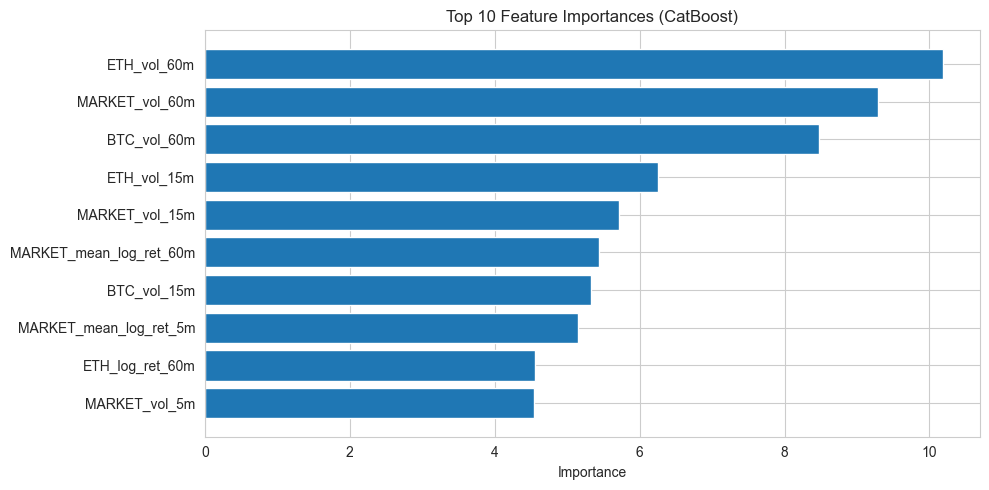

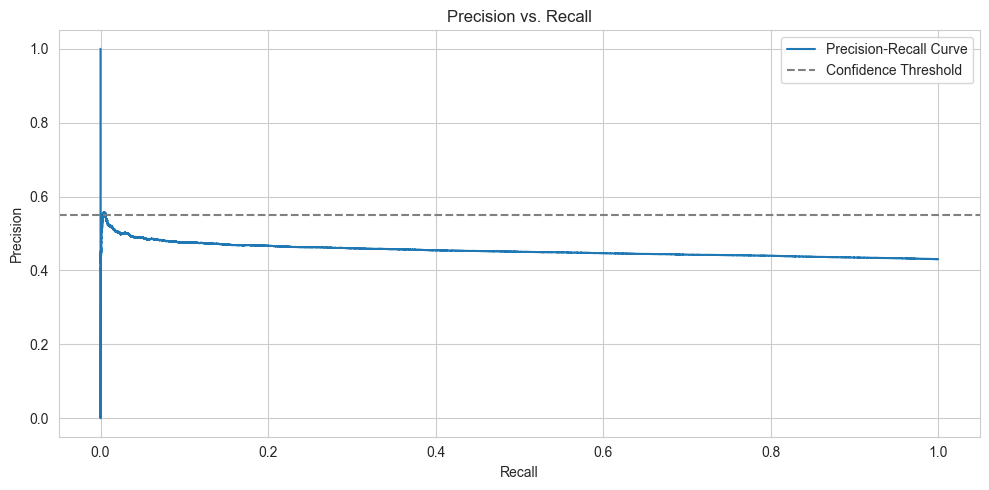

Average Precision Score: 0.4543


In [95]:
# 5) Feature importance + precision-recall analysis
importances = pd.Series(cat_final_model.get_feature_importance(), index=dataset.columns)
top_features = importances.sort_values(ascending=False).head(10)

# Validate and plot feature importances
print(f"Top features shape: {top_features.shape}")
print(f"Top features:\n{top_features}")

# Filter out non-finite values before plotting
top_features_finite = top_features[np.isfinite(top_features.values)]

plt.figure(figsize=(10, 5))
if len(top_features_finite) > 0 and top_features_finite.values.sum() > 0:
    # Use matplotlib directly instead of seaborn for more robustness
    plt.barh(range(len(top_features_finite)), top_features_finite.values)
    plt.yticks(range(len(top_features_finite)), top_features_finite.index)
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances (CatBoost)')
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.tight_layout()
    plt.show()
else:
    print("No valid finite feature importances to plot")
    plt.close()

precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.axhline(y=CONFIDENCE_THRESHOLD, color='gray', linestyle='--', label='Confidence Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.legend()
plt.tight_layout()
plt.show()
avg_precision = average_precision_score(y_test, test_probs)
print(f'Average Precision Score: {avg_precision:.4f}')

In [96]:
# 7) Summary diagnostics
final_report = classification_report(y_test, test_preds, digits=4)
print('Test Classification Report:', final_report)
print(f'Average Precision: {avg_precision:.4f}')
cat_final_model.save_model(str(CAT_MODEL_PATH))
print(f'Saved CatBoost model to {CAT_MODEL_PATH}')


Test Classification Report:               precision    recall  f1-score   support

           0     0.5748    0.9067    0.7036    178837
           1     0.4755    0.1120    0.1813    135060

    accuracy                         0.5648    313897
   macro avg     0.5252    0.5094    0.4425    313897
weighted avg     0.5321    0.5648    0.4789    313897

Average Precision: 0.4543
Saved CatBoost model to eth_golden_trio_cat.cbm
